# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle
from scipy import stats

from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx

import arviz as az

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams["figure.figsize"] = (6, 4)
# mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

# System parameters

In [4]:
# from exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=258796169

epoch_tess = ufloat(2459448.706988, 0.0014133087)
period_tess = ufloat(1.5538099249565, 0.00000951238)

# epoch_tess = ufloat(2459445.33826, 2.85235) # alternative epoch
# period_tess = ufloat(35.98, 0.16) # alternative period

depth_tess = ufloat(3330.156644324, 456.53528) # ppm
duration_tess = ufloat(1.0037931966707, 0.13730182)  # hours
radius_tess = ufloat(1.2223160327324, 0.7920717) # R_earth
insolation_tess = 17.981625116353 # S_earth

stteff_tess = ufloat(3244, 157)
strad_tess = ufloat(0.19272899627685, 0.00578436)
stmass_tess = ufloat(0.161878, 0.0200574)

# RV reading

In [5]:
lbl_gl410 = pd.read_table('./lbl_toi4616_gl410/lbl_TOI4616_GL410.rdb', sep=None, engine='python', header=0)
lbl_gl699 = pd.read_table('./lbl_toi4616_gl699/lbl_TOI4616_GL699.rdb', sep=None, engine='python', header=0)
lbl2_gl699 = pd.read_table('./lbl_toi4616_gl699/lbl2_TOI4616_GL699.rdb', sep=None, engine='python', header=0)
lbl2_gl699_new = pd.read_table('./new_montreal/lbl2_TOI4616_GL699_bervzp.rdb', sep=None, engine='python', header=0)
#lbl_toi4616 = pd.read_table('./lbl_toi4616_toi4616/lbl_TOI4616_TOI4616.rdb', sep=None, engine='python', header=0) # not used, really bad data

lbl2_gl905_car = pd.read_table('./lbl2_carmona/lbl2_TOI4616_GL905.rdb', sep=None, engine='python', header=0)
lbl2_gl905_car_vtot10 = pd.read_table('./lbl2_carmona/lbl2_TOI4616_GL905_Vtot10corr.rdb', sep='\s+', engine='python', header=0)

lbl2_gl699_car = pd.read_table('./lbl2_carmona/lbl2_TOI4616_GL699.rdb', sep=None, engine='python', header=0)
lbl2_gl699_car_vtot10 = pd.read_table('./lbl2_carmona/lbl2_TOI4616_GL699_Vtot10corr.rdb', sep='\s+', engine='python', header=0)

lbl2_toi4616_car = pd.read_table('./lbl2_carmona/lbl2_TOI4616_TOI4616.rdb', sep=None, engine='python', header=0)

names = ['lbl2_gl699', 'lbl2_gl699_new']
#names = ['lbl2_gl905_car', 'lbl2_gl699_car', 'lbl2_toi4616_car']
#names = ['lbl2_gl905_car_vtot10', 'lbl2_gl699_car_vtot10']

star_name = 'toi4616'

In [6]:
print(len(lbl_gl410), len(lbl_gl699), len(lbl2_gl905_car), len(lbl2_gl699_car), len(lbl2_toi4616_car), len(lbl2_gl905_car_vtot10), len(lbl2_gl699_car_vtot10))

24 68 18 18 18 16 16


In [9]:
datasets = list([lbl2_gl699, lbl2_gl699_new])
#datasets = list([lbl2_gl905_car, lbl2_gl699_car, lbl2_toi4616_car])
#datasets = list([lbl2_gl905_car_vtot10, lbl2_gl699_car_vtot10])

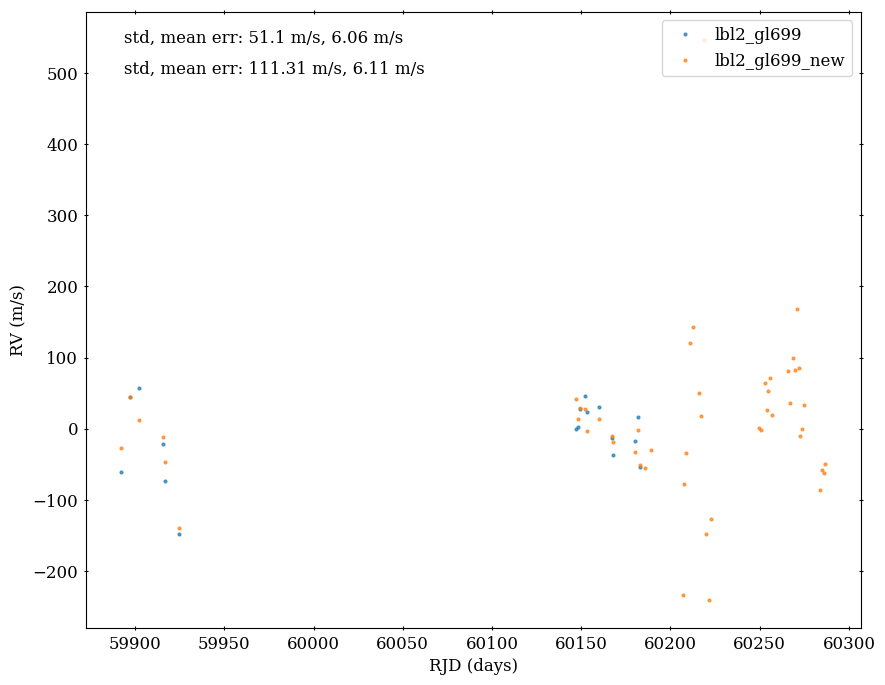

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, data in enumerate(datasets):
    ax.plot(data['rjd'], data['vrad']-np.median(data['vrad']), 'o', ms=2, label=names[i], alpha=0.7)
    ax.set_ylabel('RV (m/s)')
    ax.set_xlabel('RJD (days)')
    ax.text(0.05, 0.95-i*0.05, 'std, mean err: '+str(round(np.std(data['vrad']), 2))+' m/s, '+str(round(np.mean(data['svrad']),2))+' m/s', transform=ax.transAxes)
ax.legend(loc='upper right')
plt.savefig('rvs_'+star_name+'.png', dpi=300, facecolor='w')
plt.show()

## outliers?

In [11]:
for i in range(len(datasets)):
    print(datasets[i].shape)

(17, 172)
(50, 185)


In [12]:
outliers = []
for k, data in enumerate(datasets):
    sigmas = 3
    datasets[k] = data[np.abs(data['vrad'] - data['vrad'].median()) <= (sigmas * data['vrad'].std())].reset_index(drop=True)
    a = np.abs(data['vrad'] - data['vrad'].mean()) <= (3 * data['vrad'].std())
    outliers.append(np.size(a) - np.count_nonzero(a))
print(outliers)

[0, 1]


In [13]:
# substract the systemic velocity 
for i in datasets:
    i['vrad'] = i['vrad'].apply(lambda x: x - i['vrad'].median())

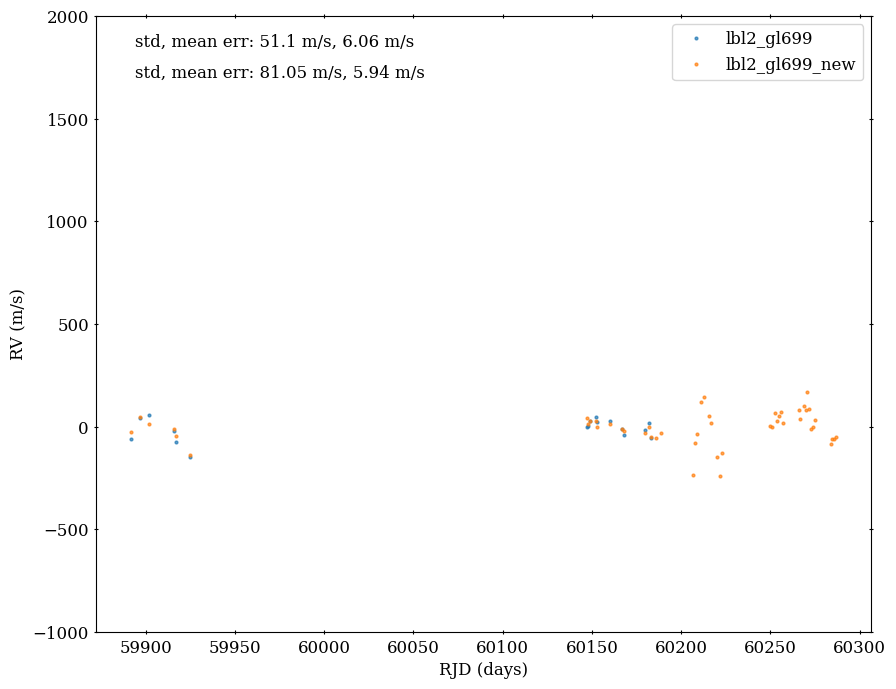

In [14]:
# replot without outliers
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, data in enumerate(datasets):
    ax.plot(data['rjd'], data['vrad']-np.median(data['vrad']), 'o', ms=2, label=names[i], alpha=0.7)
    ax.set_ylabel('RV (m/s)')
    ax.set_xlabel('RJD (days)')
    ax.text(0.05, 0.95-i*0.05, 'std, mean err: '+str(round(np.std(data['vrad']), 2))+' m/s, '+str(round(np.mean(data['svrad']),2))+' m/s', transform=ax.transAxes)
ax.legend(loc='upper right')
plt.ylim(-1000, 2000)
plt.show()

# GLS

In [15]:
ls = dict()
frequency = dict()
power = dict()
faps = dict()

for k, data in enumerate(datasets):
    ls[k] = LombScargle(data['rjd'], data['vrad'], data['svrad'])
    frequency[k], power[k] = ls[k].autopower(minimum_frequency=0.01, maximum_frequency=2, samples_per_peak=15)
    probabilities = [0.05]
    faps[k] = ls[k].false_alarm_level(probabilities)

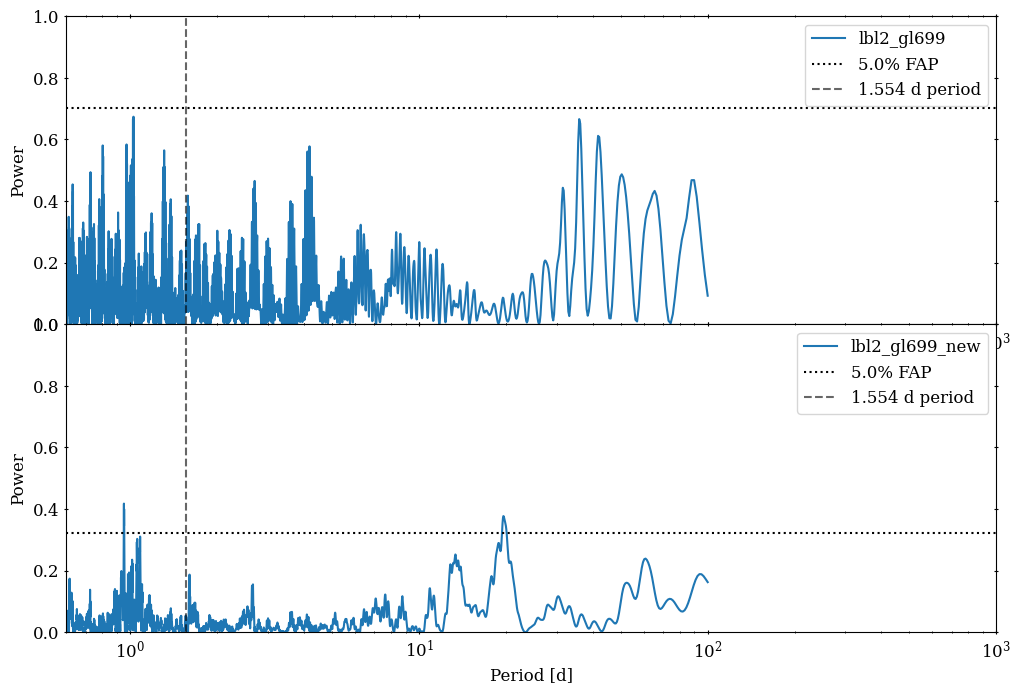

In [16]:
fig, axes = plt.subplots(len(datasets),1, sharex=False, figsize=(12, 4*len(datasets)))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(len(datasets)):
    axes[i].plot(1/frequency[i], power[i], label=names[i])
    axes[i].axhline(faps[i], ls=':', color='black', label='{}% FAP'.format(probabilities[0]*100))
    axes[i].set_xscale('log')
    axes[i].set_xlim(0.6, 1000)
    axes[i].set_ylim(0, 1.0)
    axes[i].set_ylabel('Power')
    axes[i].set_xlabel('Period [d]')
    axes[i].axvline(period_tess.n, ls='--', color='black', alpha=0.6, label='{} d period'.format(round(period_tess.n, 3)))
    # axes[i].axvline(1.553, ls='--', color='black', alpha=0.6, label='{} d period'.format(round(1.553, 3)))
    axes[i].legend(loc='upper right')
    axes[i].set_ylim(0, 1)

# plt.savefig('gls.png', dpi=300, facecolor='w', bbox_inches='tight')

# RV fit 

In [17]:
x_ref = dict()
maxrv = dict()
Kest = dict()

for k, data in enumerate(datasets):
    x_ref[k] = 0.5 * (data['rjd'].min() + data['rjd'].max())
    maxrv[k] = np.std(data['vrad'])*3
    Kest[k] = xo.estimate_semi_amplitude(period_tess.n, data['rjd'], data['vrad'], data['svrad'])
    print('Kest:', Kest[k])

Kest: [25.50300559]
Kest: [26.05200697]


In [18]:
# Make a fine grid that spans the observation window for plotting purposes
model = dict()
t = dict()

for k, data in enumerate(datasets):
    t[k] = np.linspace(data['rjd'].min() - 5, data['rjd'].max() + 5, 3000)

    with pm.Model() as model[k]:
        logP = pm.Normal("logP", mu=np.log(period_tess.n), sd=period_tess.s/period_tess.n) #period_tess.s/period_tess.n
        P = pm.Deterministic("P", tt.exp(logP))
        #K = pm.Uniform("K", lower=0, upper=maxrv[k])
        logK = pm.Normal("logK", mu=np.log(Kest[k].item()), sd=2.0, testval=np.log(Kest[k].item()))
        K = pm.Deterministic("K", tt.exp(logK))

        logs = pm.Normal("logs", mu=np.log(np.median(data['svrad'])), sd=5.0)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)  # [2,1,0]

        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1)
        mstar = BoundedNormal("mstar", mu=stmass_tess.n, sd=stmass_tess.s)
        rstar = BoundedNormal("rstar", mu=strad_tess.n, sd=strad_tess.s)

        t0 = pm.Normal("t0", mu=epoch_tess.n-2400000, sd=epoch_tess.s)
        #t0 = pm.Uniform("t0", lower=epoch_tess.n-2400000-10, upper=epoch_tess.n-2400000+10)
        orbit = xo.orbits.KeplerianOrbit(period=P, 
                                        t0=t0, 
                                        r_star=rstar, 
                                        m_star=mstar)

        # derive mass and semi-major axis
        m_pl = pm.Deterministic('m_pl', K*(P*u.day.to(u.second)*(mstar*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3))
        a = pm.Deterministic('a', ((P*u.day.to(u.second))**2*constants.G*(mstar*u.M_sun.to(u.kg)+m_pl)/(4*np.pi**2))**(1/3)*u.m.to(u.au))

        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t, K=K)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref[k], 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)

        # Define the RVs at the observed times
        rv_model = get_rv_model(data['rjd'])
        # Also define the model on a fine grid as computed above (for plotting)
        rv_model_pred = get_rv_model(t[k], name="_pred")

        # Finally add in the observation model. 
        err = tt.sqrt(np.asarray(data['svrad'])**2  + tt.exp(2 * logs))
        pm.Normal("obs", mu=rv_model, sd=err, observed=data['vrad'])

In [19]:
for i in range(len(datasets)):
    with model[i]:
        map_soln = pmx.optimize(start=model[i].test_point)
        #map_soln = pmx.optimize(start=map_soln, vars=[logP, K, logs, t0])
        map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [t0, rstar, mstar, trend, logs, logK, logP]


message: Optimization terminated successfully.
logp: -1843.3333506819838 -> -69.032732661307
optimizing logp for variables: [t0, rstar, mstar, trend, logs, logK, logP]


message: Optimization terminated successfully.
logp: -69.032732661307 -> -69.032732661307


optimizing logp for variables: [t0, rstar, mstar, trend, logs, logK, logP]


message: Optimization terminated successfully.
logp: -3902.561515625197 -> -263.6714001073564
optimizing logp for variables: [t0, rstar, mstar, trend, logs, logK, logP]


message: Optimization terminated successfully.
logp: -263.6714001073564 -> -263.6714001073564


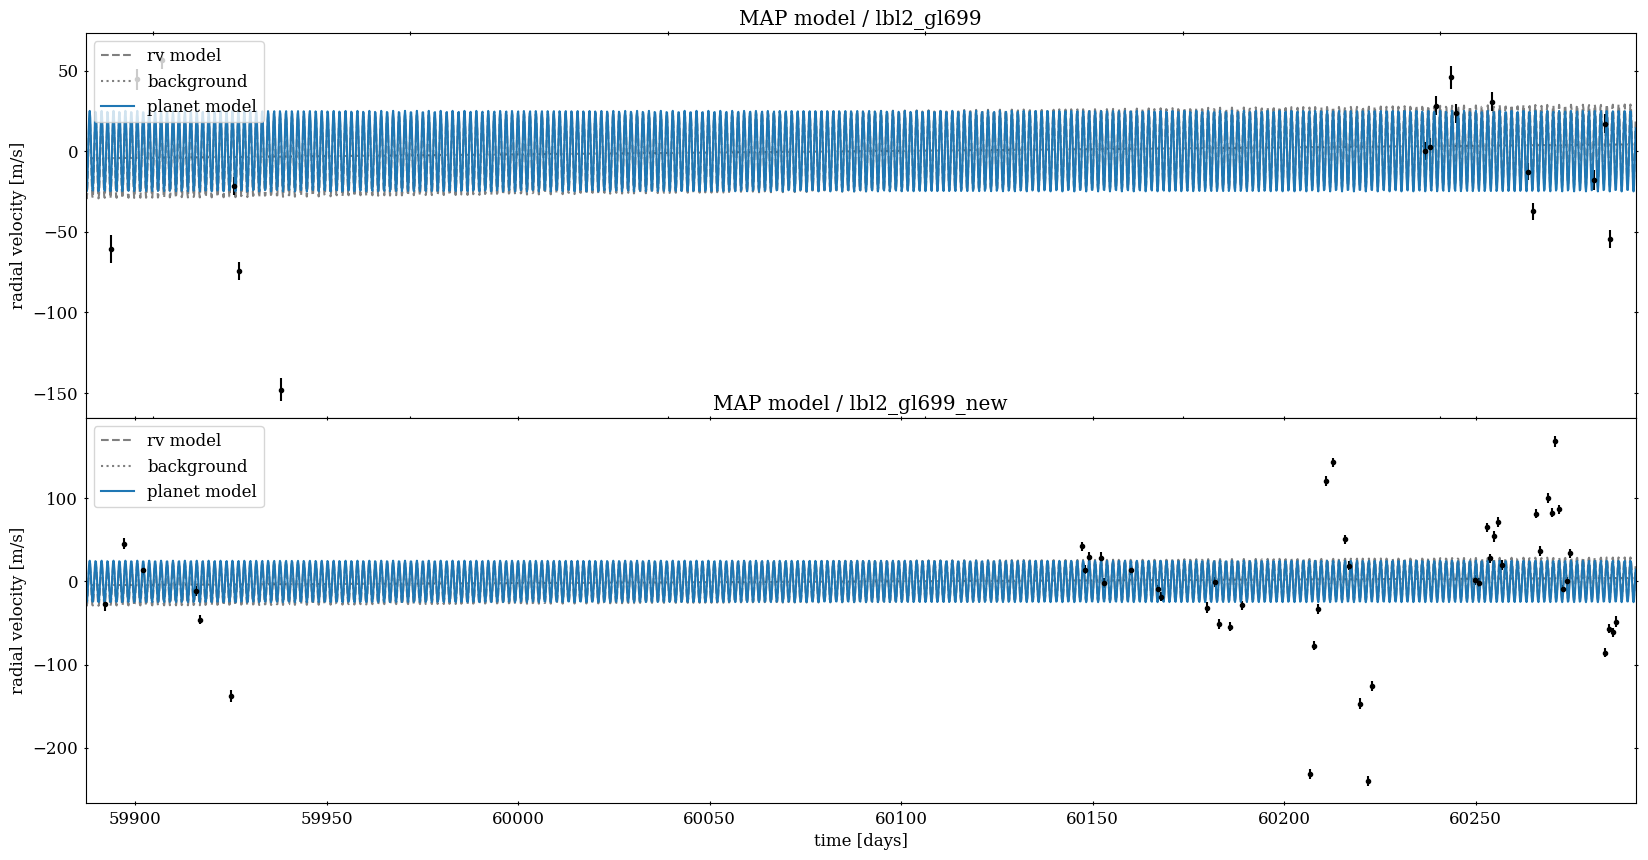

In [20]:
fig, ax = plt.subplots(len(datasets), 1, figsize=(20, 5*len(datasets)))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for k, data in enumerate(datasets):
    ax[k].errorbar(data['rjd'], data['vrad'], yerr=data['svrad'], fmt=".k")
    ax[k].plot(t[k], map_soln["rv_model_pred"], "--k", alpha=0.5, label='rv model')
    ax[k].plot(t[k], map_soln["bkg_pred"], ":k", alpha=0.5, label="background")
    ax[k].plot(t[k], map_soln["vrad_pred"], label="planet model")

    ax[k].legend(loc="upper left")
    ax[k].set_xlim(t[k].min(), t[k].max())
    ax[k].set_xlabel("time [days]")
    ax[k].set_ylabel("radial velocity [m/s]")
    _ = ax[k].set_title("MAP model"+' / '+names[k])

# Sampling

In [21]:
traces = dict()
for k, data in enumerate(datasets):
    with model[k]:
        traces[k] = pmx.sample(
            tune=2000,
            draws=2000,
            cores=2,
            chains=2,
            target_accept=0.95,
            return_inferencedata=True,
        )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0, rstar, mstar, trend, logs, logK, logP]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0, rstar, mstar, trend, logs, logK, logP]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [22]:
summary = dict()
for k, data in enumerate(datasets):
    summary[k] = az.summary(traces[k], stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.997, round_to=6,
                var_names=[
                    't0', 'logP', 'P', 'K', 'logs', 'trend', 'mstar', 'rstar', 'm_pl', 'a'
                    ])
    print(summary[k].ess_bulk.mean(), summary[k].ess_tail.mean(), summary[k].r_hat.max())


3528.2303289166666 2466.55915075 1.001458
3722.0693690833336 2593.314667666667 1.000927


In [23]:
summary[0]

,mean,sd,hdi_0.15%,hdi_99.85%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
t0,5.944871e+04,1.428000e-03,5.944870e+04,5.944871e+04,2.300000e-05,1.600000e-05,3936.518845,2983.435818,1.000734,5.944871e+04,1.428000e-03
logP,4.407100e-01,6.000000e-06,4.406920e-01,4.407280e-01,0.000000e+00,0.000000e+00,4340.489533,2845.217970,1.000108,4.407100e-01,6.000000e-06
P,1.553810e+00,9.000000e-06,1.553783e+00,1.553838e+00,0.000000e+00,0.000000e+00,4340.489533,2845.217970,1.000108,1.553810e+00,9.000000e-06
K,2.024150e+01,1.452624e+01,3.797900e-02,6.848407e+01,2.822780e-01,1.996230e-01,2030.001177,1590.822062,1.000178,1.809392e+01,1.452443e+01
logs,3.919852e+00,1.953840e-01,3.357723e+00,4.556202e+00,3.796000e-03,2.710000e-03,2769.658921,2217.184459,1.000995,3.908782e+00,1.953600e-01
trend[0],-8.050000e-04,7.860000e-04,-3.438000e-03,1.559000e-03,1.400000e-05,1.200000e-05,3348.068111,2146.316674,1.001458,-7.980000e-04,7.860000e-04
trend[1],3.912300e-02,7.148100e-02,-2.240410e-01,2.302380e-01,1.155000e-03,9.740000e-04,3870.721498,2560.673502,1.001223,3.981400e-02,7.147200e-02
trend[2],-3.586900e-02,1.002486e+00,-3.126147e+00,2.822640e+00,1.596700e-02,1.516900e-02,3956.402963,3024.153246,1.000712,-3.099600e-02,1.002360e+00
mstar,1.621970e-01,2.024900e-02,1.035520e-01,2.217680e-01,3.270000e-04,2.310000e-04,3884.363927,2516.831669,1.000958,1.622760e-01,2.024600e-02
rstar,1.927520e-01,5.712000e-03,1.760390e-01,2.087560e-01,9.100000e-05,6.400000e-05,3936.808272,2786.409227,0.999942,1.927660e-01,5.711000e-03


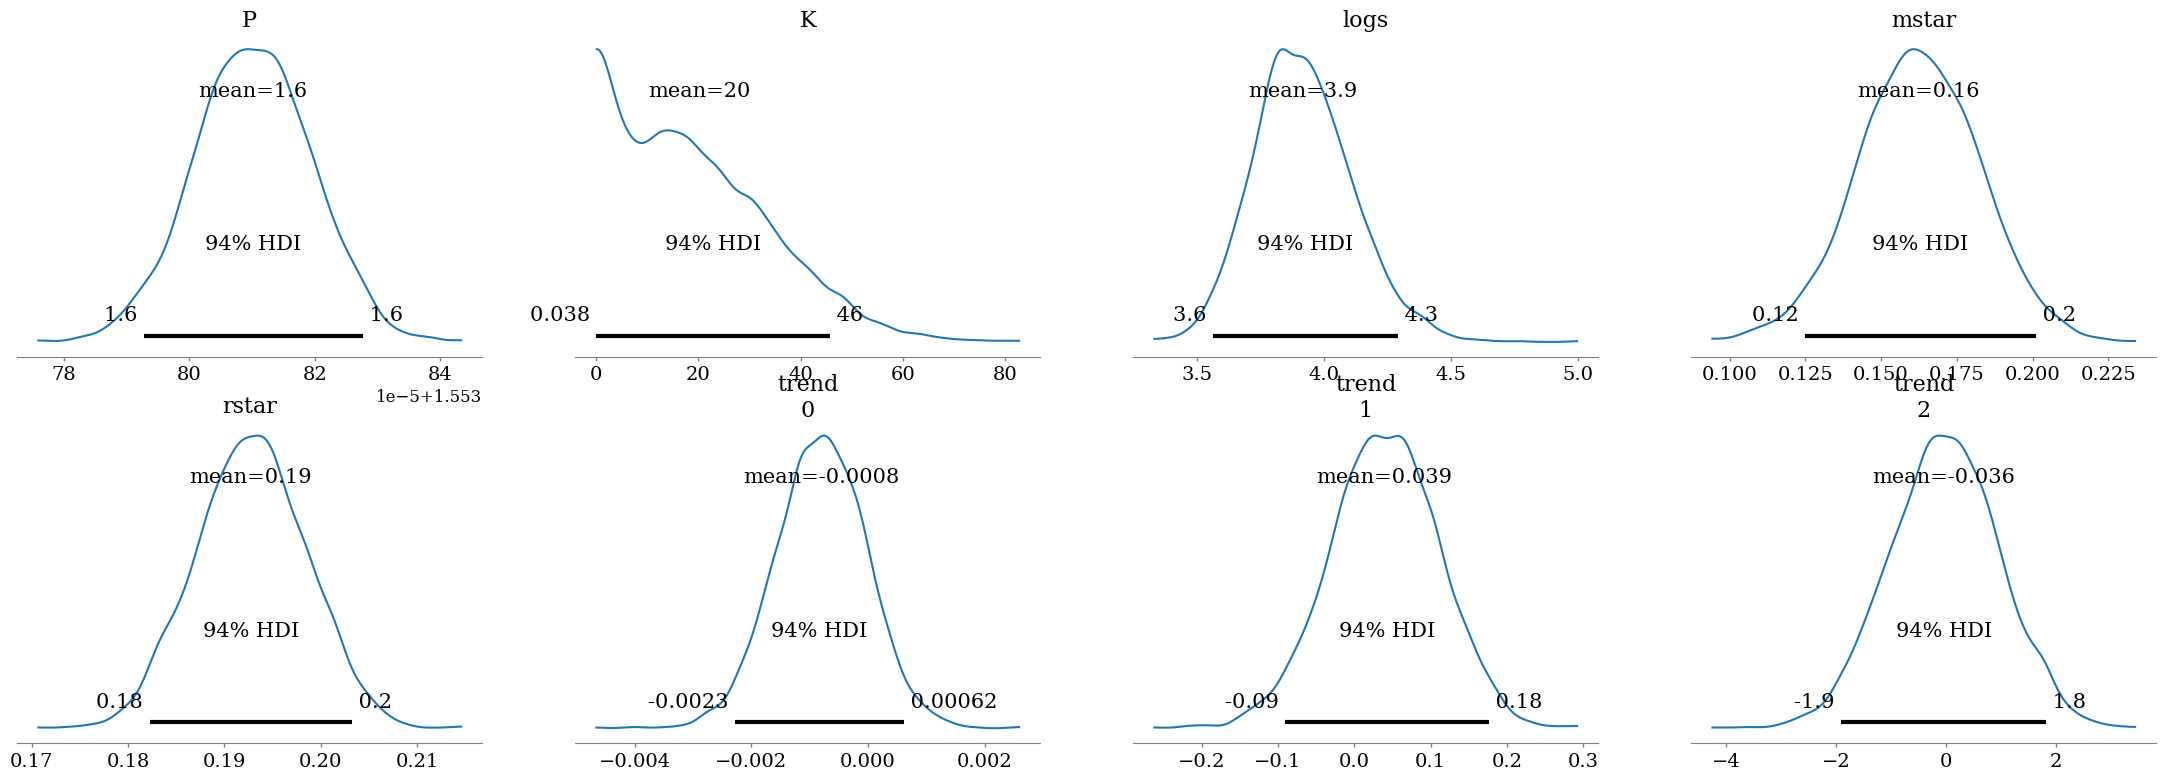

In [24]:
az.plot_posterior(traces[0], var_names=['P', 'K', 'logs', 'mstar', 'rstar', 'trend'])
plt.show()

## Results

In [25]:
mass = dict()
K = dict()
period = dict()
t_0 = dict()
m_star = dict()
r_star = dict()
smaxis = dict()
rv_jitter_ = dict()
bkg_ = dict()
rv_model = dict()
rv_model_pred = dict()
rv_model_pred_ = dict()
flat_samps = dict()

for i in range(len(datasets)):
    mass[i] = ufloat((traces[i].posterior["m_pl"].median().item()*u.kg).to(u.M_earth).value, (traces[i].posterior["m_pl"].std().item()*u.kg).to(u.M_earth).value)
    K[i] = ufloat(traces[i].posterior["K"].median().item(), traces[i].posterior["K"].std().item())
    period[i] = ufloat(traces[i].posterior['P'].median().item(),traces[i].posterior['P'].std().item())
    t_0[i] = ufloat(traces[i].posterior['t0'].median().item(), traces[i].posterior['t0'].std().item())
    m_star[i] = ufloat(traces[i].posterior['mstar'].median().item(), traces[i].posterior['mstar'].std().item())
    r_star[i] = ufloat(traces[i].posterior['rstar'].median().item(), traces[i].posterior['rstar'].std().item())
    smaxis[i] = ufloat(traces[i].posterior['a'].median().item(), traces[i].posterior['a'].std().item())
    logsigma_rv = ufloat(traces[i].posterior["logs"].median().item(), traces[i].posterior["logs"].std().item())
    rv_jitter_[i] = np.e**logsigma_rv
    flat_samps[i] = traces[i].posterior.stack(sample=("chain", "draw"))
    bkg_[i] = np.median(flat_samps[i]['bkg'].values, axis=-1)
    rv_model[i] = np.median(flat_samps[i]['rv_model'].values, axis=-1)

    rv_model_pred[i] = np.median(flat_samps[i]['rv_model_pred'].values, axis=-1)
    rv_model_pred_[i] = np.percentile(traces[i].posterior["rv_model_pred"].values,[16, 50, 84], axis=(0, 1))

    print('REDUCTION: ', names[i])
    print("Mp = {m:.3f} Mearth".format(m=mass[i]))
    print('K = {k:.3f} m/s'.format(k=K[i]))
    print("P = {p:.6f} days".format(p=period[i]))
    print("Epoch = {e:.5f}".format(e=t_0[i]))
    print('a = {a:.4f} AU'.format(a=smaxis[i]))
    print('mstar = {m:.3f} Msun'.format(m=m_star[i]))
    print('rstar = {r:.3f} Rsun'.format(r=r_star[i]))
    print("RV jitter = ", rv_jitter_[i])
    print('---------------------------------------------')

REDUCTION:  lbl2_gl699
Mp = 9.529+/-7.906 Mearth
K = 18.094+/-14.524 m/s
P = 1.553810+/-0.000009 days
Epoch = 59448.70703+/-0.00143
a = 0.0143+/-0.0006 AU
mstar = 0.162+/-0.020 Msun
rstar = 0.193+/-0.006 Rsun
RV jitter =  50+/-10
---------------------------------------------
REDUCTION:  lbl2_gl699_new
Mp = 7.732+/-7.307 Mearth
K = 14.518+/-13.446 m/s
P = 1.553810+/-0.000010 days
Epoch = 59448.70703+/-0.00144
a = 0.0143+/-0.0006 AU
mstar = 0.162+/-0.021 Msun
rstar = 0.193+/-0.006 Rsun
RV jitter =  81+/-8
---------------------------------------------


## Plot results

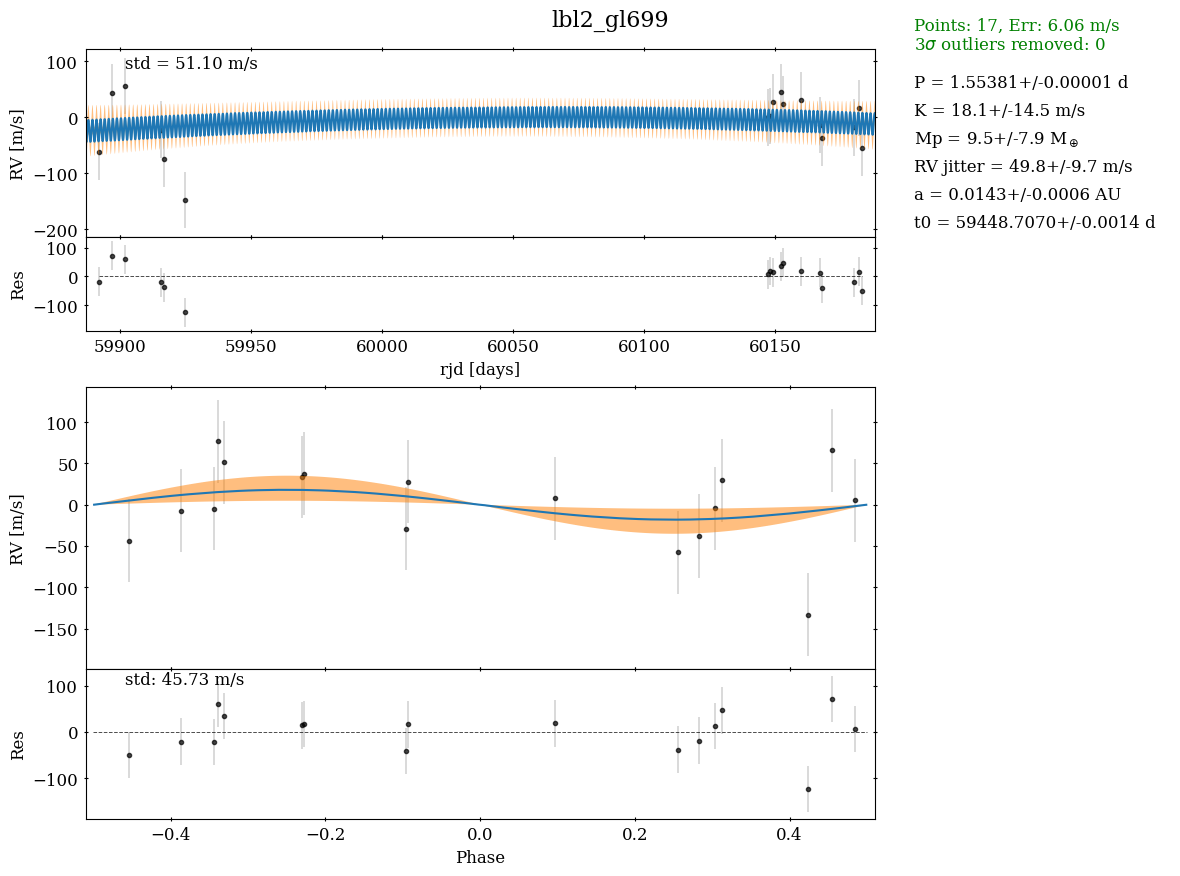

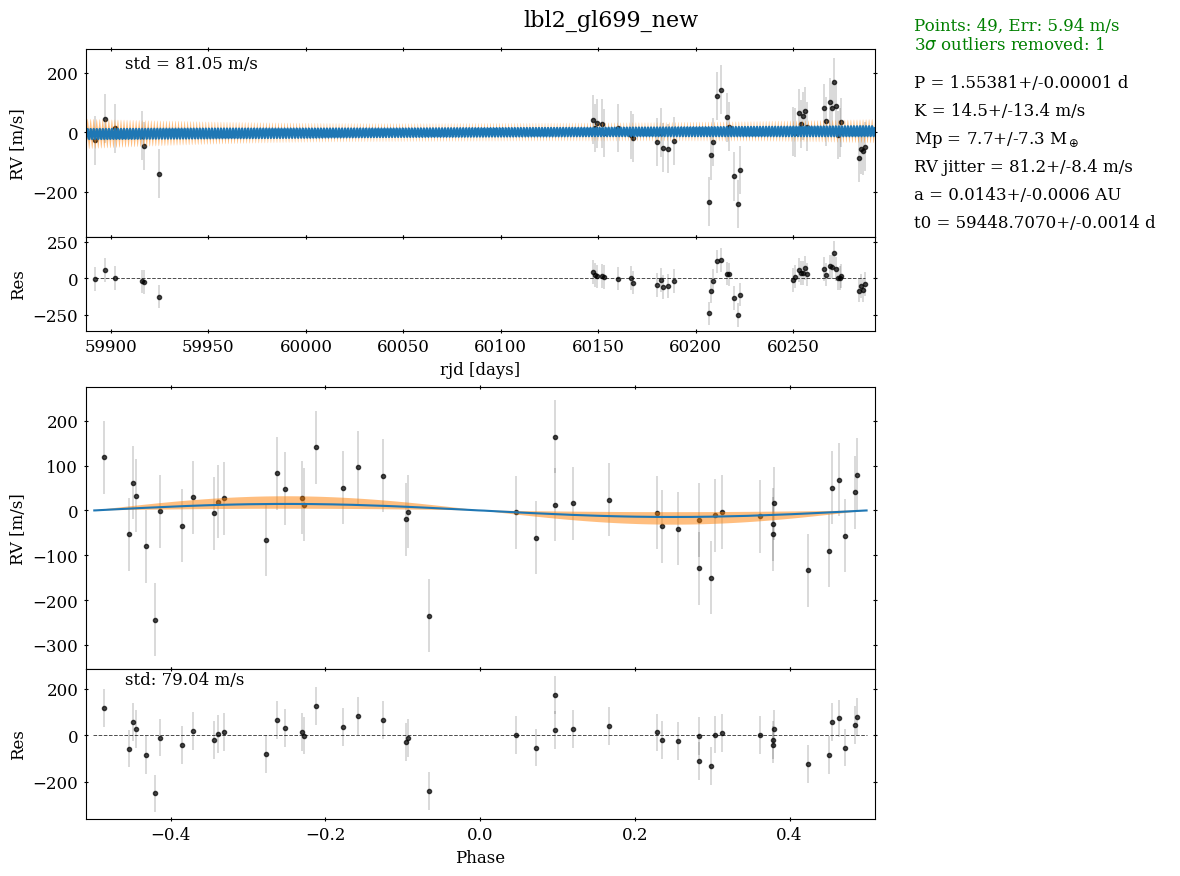

In [26]:
# make a grid of 3 subplots in a column
gs_kw = dict(width_ratios=[4,1], height_ratios=[1, 0.5, 0.3, 1.5, 0.8], hspace=0.0)

new_rvs = []

for k, data in enumerate(datasets):
    if k==1:
        new_rvs.append(data['vrad']-rv_model[k])
    fig, ax = plt.subplots(5, 2, figsize=(14, 10), gridspec_kw=gs_kw)
    fig.suptitle(names[k], y=0.92, fontsize=16)
    # delete the three empty subplots and add the parameters in text
    for i in range(5):
        ax[i,1].xaxis.set_visible(False)
        ax[i,1].yaxis.set_visible(False)
        ax[i,1].spines['left'].set_visible(False)
        ax[i,1].spines['right'].set_visible(False)
        ax[i,1].spines['top'].set_visible(False)
        ax[i,1].spines['bottom'].set_visible(False)
        if i==0 or i==3:
            ax[i,0].set_xticks([])
            ax[i,0].set_xticklabels([])

    ax[0,1].text(-0.3, 1.1, 'Points: {o}, Err: {r:.2f} m/s'.format(o=len(data['vrad']), r=np.mean(data['svrad'])), fontsize=12, color='g')
    ax[0,1].text(-0.3, 1, '3$\sigma$ outliers removed: {o}'.format(o=outliers[k]), fontsize=12, color='g')
    ax[0,1].text(-0.3, 0.8, 'P = {p:.5f} d'.format(p=period[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.65, 'K = {k:.1f} m/s'.format(k=K[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.5, 'Mp = {m:.1f} M$_\oplus$'.format(m=mass[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.35, 'RV jitter = {j:.1f} m/s'.format(j=rv_jitter_[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.2, 'a = {a:.4f} AU'.format(a=smaxis[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.05, 't0 = {t:.4f} d'.format(t=t_0[k]), fontsize=12)
    
    # plot the RVs and the model in the first subplot
    ax[0,0].errorbar(data['rjd'], data['vrad'], yerr=np.sqrt(data['svrad']**2+rv_jitter_[k].n**2), fmt=".k", label='rvs', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax[0,0].plot(t[k], rv_model_pred_[k][1], label='model')
    art = ax[0,0].fill_between(t[k], rv_model_pred_[k][0], rv_model_pred_[k][2], color="#FF7F00", alpha=0.5) 
    art.set_edgecolor("none")
    ax[0,0].set_ylabel("RV [m/s]")

    # add initial dispersion
    ax[0,0].text(0.05, 0.90, 'std = {s:.2f} m/s'.format(s=np.std(data['vrad'])), fontsize=12, transform=ax[0,0].transAxes)
    ax[0,0].sharex(ax[1,0])
    # add the residuals in the second subplot
    ax[1,0].hlines(0, data['rjd'].min(), data['rjd'].max(), ls='--', lw=0.7, alpha=0.7, color='k')
    ax[1,0].errorbar(data['rjd'], data['vrad']-rv_model[k], yerr=np.sqrt(data['svrad']**2+rv_jitter_[k].n**2), fmt=".k", 
                    label='residuals', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax[1,0].set_xlim(data['rjd'].min()-5, data['rjd'].max()+5)
    ax[1,0].set_xlabel("rjd [days]")
    ax[1,0].set_ylabel("Res")
    # plot the folded data
    x_fold = (data['rjd'] - t_0[k].n + 0.5 * period[k].n) % period[k].n - 0.5 * period[k].n
    ax[3,0].errorbar(x_fold/period[k].n, data['vrad']-bkg_[k], yerr=np.sqrt(data['svrad']**2+rv_jitter_[k].n**2), fmt=".k",
                markeredgecolor='k', ecolor='k', elinewidth=0.3, label='', alpha=0.7, zorder=-10) 
    # delete the third subplot so it shows as a gap
    ax[2,0].set_visible(False)

    # compute the posterior prediction for the folded RV model
    t_fold = (t[k] - t_0[k].n + 0.5 * period[k].n) % period[k].n - 0.5 * period[k].n
    inds = np.argsort(t_fold)
    pred_rvs = np.percentile(traces[k].posterior["vrad_pred"].values,[16, 50, 84], axis=(0, 1))
    ax[3,0].plot(t_fold[inds]/period[k].n, pred_rvs[1][inds], label='folded model')
    art = ax[3,0].fill_between(t_fold[inds]/period[k].n, pred_rvs[0][inds], pred_rvs[2][inds], color="#FF7F00", alpha=0.5) 
    art.set_edgecolor("none")
    ax[3,0].set_ylabel("RV [m/s]")

    # plot the residuals
    ax[4,0].hlines(0, -0.5, 0.5, ls='--', lw=0.7, alpha=0.7, color='k')
    ax[4,0].errorbar(x_fold/period[k].n, data['vrad']-rv_model[k], yerr=np.sqrt(data['svrad']**2+rv_jitter_[k].n**2), fmt=".k", 
                    label='residuals', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax[4,0].set_xticks([-0.5, -0.25, 0, 0.25, 0.5])
    ax[4,0].set_ylabel("Res")
    ax[4,0].set_xlabel("Phase")
    # show the std of the residuals
    ax[4,0].text(0.05, 0.90, 'std: '+str(round(np.std(data['vrad']-rv_model[k]), 2))+' m/s', transform=ax[4,0].transAxes)
    ax[4,0].set_xlim(-0.51, 0.51)
    ax[4,0].set_xticks([-0.40, -0.20, 0, 0.40, 0.20])
    ax[3,0].sharex(ax[4,0])
    # savefig with name
    #plt.savefig('fit_2_'+names[k]+'.png', dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

In [27]:
def limit_mass(K, ecc, period, m_star):
    return K*np.sqrt(1-ecc**2)*(period*u.day.to(u.second)*(m_star*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3)*u.kg.to(u.M_earth)

# compute the mass upper limit from 3 sigma upper limit on K
Ks = np.percentile(traces[1].posterior["K"].values,[0.015, 50, 99.85], axis=(0, 1))
limit_mass(Ks[2], 0.0, period[1], stmass_tess.n).n

36.517935868605456